In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import kagglehub
chitholian_annotated_potholes_dataset_path = "/content/drive/MyDrive/157-Potholes-Compressed/annotated-potholes-dataset/versions/1/annotated-images"
andrewmvd_pothole_detection_path = kagglehub.dataset_download('andrewmvd/pothole-detection')
ashishkumarak_training_setzip_path = kagglehub.dataset_download('ashishkumarak/training-setzip')

print('Data source import complete.')

print("Path to dataset files:", chitholian_annotated_potholes_dataset_path)
print("Path to dataset files:", andrewmvd_pothole_detection_path)
print("Path to dataset files:", ashishkumarak_training_setzip_path)

Mounted at /content/drive
Data source import complete.
Path to dataset files: /content/drive/MyDrive/157-Potholes-Compressed/annotated-potholes-dataset/versions/1/annotated-images
Path to dataset files: /kaggle/input/pothole-detection
Path to dataset files: /kaggle/input/training-setzip


In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image, ImageDraw
from xml.dom import minidom
import csv
import torch
from tqdm.notebook import tqdm
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder

In [7]:
import re
pattern = r"(\d+)\.jpg$"
img_numbers=[]

for dirname, _, filenames in os.walk(chitholian_annotated_potholes_dataset_path):
    for filename in filenames:
        match = re.search(pattern,filename,re.IGNORECASE)
        if match:
            number = match.group(1)
            img_numbers.append(number)

img_numbers.sort()

In [8]:
def extract_xml_contents(annot_directory, image_dir, file_dir):

        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates
        xmin = file.getElementsByTagName('xmin')
        x1 = int(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = int(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = int(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = int(ymax[0].firstChild.data)

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data
        filename = os.path.join(file_dir,filename)

        return filename, width, height, x1,y1,x2,y2

### Dataset 1

In [9]:
import pandas as pd

# Function to convert XML files to CSV
def xml_to_csv(data_dir):

  # List containing all our attributes regarding each image
    xml_list = []

  # Loop over each of the image and its label
    for i in img_numbers:

        mat = f"img-{i}.xml"
        image_file = f"img-{i}.jpg"

      # Full mat path
        mat_path = os.path.join(data_dir, mat)

      # Full path Image
        img_path = os.path.join(data_dir, image_file)

      # Get Attributes for each image
        value = extract_xml_contents(mat_path, img_path,data_dir)

      # Append the attributes to the mat_list
        xml_list.append(value)

  # Columns for Pandas DataFrame
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin',
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
    xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
    return xml_df

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df1 = xml_to_csv(data_dir=chitholian_annotated_potholes_dataset_path)

# Saving the Pandas DataFrame as CSV File
labels_df1.to_csv(('dataset.csv'), index=None)

In [10]:
labels_df1

filename  width  height  xmin  \
0    /content/drive/MyDrive/157-Potholes-Compressed...    720     720   213   
1    /content/drive/MyDrive/157-Potholes-Compressed...    720     720   285   
2    /content/drive/MyDrive/157-Potholes-Compressed...    720     720   235   
3    /content/drive/MyDrive/157-Potholes-Compressed...    720     720   230   
4    /content/drive/MyDrive/157-Potholes-Compressed...    720     720   264   
..                                                 ...    ...     ...   ...   
286  /content/drive/MyDrive/157-Potholes-Compressed...    720     720   296   
287  /content/drive/MyDrive/157-Potholes-Compressed...    720     720   171   
288  /content/drive/MyDrive/157-Potholes-Compressed...    720     720   180   
289  /content/drive/MyDrive/157-Potholes-Compressed...    720     720   257   
290  /content/drive/MyDrive/157-Potholes-Compressed...    720     720   228   

     ymin  xmax  ymax  
0     240   525   378  
1     214   444   355  
2     272   434   388  
3     246   492   550  
4     251   479   366  
..    ...   ...   ...  
286   315   386   421  
287   279   524   493  
288   305   509   426  
289   306   382   409  
290   269   478   474  

[291 rows x 7 columns]

### Dataset 2

In [11]:
# Read the CSV file and rename the columns
labels_df2 = pd.read_csv("/kaggle/input/training-setzip/train/labels.csv")
labels_df2.columns = ['filename', 'LabelName', 'xmin', 'xmax', 'ymin', 'ymax']
labels_df2.drop("LabelName", axis=1, inplace=True)

# Add a new column with the image filename and path
labels_df2['filename'] = labels_df2['filename'].apply(lambda x: "/kaggle/input/training-setzip/train/images/" + x)

# Add new columns with the image height and width
heights, widths = [], []
for _, row in labels_df2.iterrows():
    height, width = cv2.imread(row['filename']).shape[:2]
    heights.append(height)
    widths.append(width)

labels_df2 = labels_df2.assign(height=heights, width=widths)

# Print the resulting DataFrame
labels_df2

filename  xmin  xmax  ymin  \
0      /kaggle/input/training-setzip/train/images/1.jpg     0   131   140   
1      /kaggle/input/training-setzip/train/images/1.jpg   168   487   279   
2      /kaggle/input/training-setzip/train/images/1.jpg     1   144    34   
3      /kaggle/input/training-setzip/train/images/2.jpg    57   952   271   
4      /kaggle/input/training-setzip/train/images/3.jpg   225   416   292   
...                                                 ...   ...   ...   ...   
1366  /kaggle/input/training-setzip/train/images/672...     0   182   274   
1367  /kaggle/input/training-setzip/train/images/672...     0   176   166   
1368  /kaggle/input/training-setzip/train/images/673...   121   444   114   
1369  /kaggle/input/training-setzip/train/images/674...    50   158    82   
1370  /kaggle/input/training-setzip/train/images/674...    99   148    44   

      ymax  height  width  
0      263     720    720  
1      449     720    720  
2      109     720    720  
3      505     600   1200  
4      439     720    720  
...    ...     ...    ...  
1366   370     484    726  
1367   227     484    726  
1368   188     387    620  
1369   168     183    275  
1370    73     183    275  

[1371 rows x 7 columns]

In [12]:
# Read the CSV file and rename the columns
# Use the path obtained from kagglehub.dataset_download instead of the Kaggle-specific path
labels_df2 = pd.read_csv(os.path.join(ashishkumarak_training_setzip_path, "train/labels.csv"))
labels_df2.columns = ['filename', 'LabelName', 'xmin', 'xmax', 'ymin', 'ymax']
labels_df2.drop("LabelName", axis=1, inplace=True)

# Add a new column with the image filename and path
# Update the image path to be relative to the downloaded dataset path
labels_df2['filename'] = labels_df2['filename'].apply(lambda x: os.path.join(ashishkumarak_training_setzip_path, "train/images/", x))

# Add new columns with the image height and width
heights, widths = [], []
for _, row in labels_df2.iterrows():
    # Ensure the image file exists before trying to read it
    img_full_path = row['filename']
    if os.path.exists(img_full_path):
        height, width = cv2.imread(img_full_path).shape[:2]
        heights.append(height)
        widths.append(width)
    else:
        # Handle cases where the image file might be missing (optional)
        print(f"Warning: Image file not found at {img_full_path}")
        heights.append(None) # Or some other placeholder
        widths.append(None) # Or some other placeholder


labels_df2 = labels_df2.assign(height=heights, width=widths)

# Print the resulting DataFrame
labels_df2

filename  xmin  xmax  ymin  \
0      /kaggle/input/training-setzip/train/images/1.jpg     0   131   140   
1      /kaggle/input/training-setzip/train/images/1.jpg   168   487   279   
2      /kaggle/input/training-setzip/train/images/1.jpg     1   144    34   
3      /kaggle/input/training-setzip/train/images/2.jpg    57   952   271   
4      /kaggle/input/training-setzip/train/images/3.jpg   225   416   292   
...                                                 ...   ...   ...   ...   
1366  /kaggle/input/training-setzip/train/images/672...     0   182   274   
1367  /kaggle/input/training-setzip/train/images/672...     0   176   166   
1368  /kaggle/input/training-setzip/train/images/673...   121   444   114   
1369  /kaggle/input/training-setzip/train/images/674...    50   158    82   
1370  /kaggle/input/training-setzip/train/images/674...    99   148    44   

      ymax  height  width  
0      263     720    720  
1      449     720    720  
2      109     720    720  
3      505     600   1200  
4      439     720    720  
...    ...     ...    ...  
1366   370     484    726  
1367   227     484    726  
1368   188     387    620  
1369   168     183    275  
1370    73     183    275  

[1371 rows x 7 columns]

In [13]:
labels_df = pd.concat([labels_df1,labels_df2],axis=0)
labels_df

filename  width  height  xmin  \
0     /content/drive/MyDrive/157-Potholes-Compressed...    720     720   213   
1     /content/drive/MyDrive/157-Potholes-Compressed...    720     720   285   
2     /content/drive/MyDrive/157-Potholes-Compressed...    720     720   235   
3     /content/drive/MyDrive/157-Potholes-Compressed...    720     720   230   
4     /content/drive/MyDrive/157-Potholes-Compressed...    720     720   264   
...                                                 ...    ...     ...   ...   
1366  /kaggle/input/training-setzip/train/images/672...    726     484     0   
1367  /kaggle/input/training-setzip/train/images/672...    726     484     0   
1368  /kaggle/input/training-setzip/train/images/673...    620     387   121   
1369  /kaggle/input/training-setzip/train/images/674...    275     183    50   
1370  /kaggle/input/training-setzip/train/images/674...    275     183    99   

      ymin  xmax  ymax  
0      240   525   378  
1      214   444   355  
2      272   434   388  
3      246   492   550  
4      251   479   366  
...    ...   ...   ...  
1366   274   182   370  
1367   166   176   227  
1368   114   444   188  
1369    82   158   168  
1370    44   148    73  

[1662 rows x 7 columns]

In [14]:
DATA_DIR = chitholian_annotated_potholes_dataset_path

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
IMG_SIZE = 128
LR = 0.01
EPOCHS = 30
MODEL_NAME = "res2net50d.in1k"
NUM_COR = 4

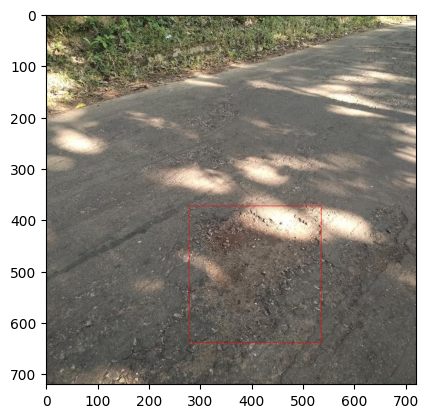

In [16]:
row = labels_df.iloc[12]

img = cv2.imread(row.filename)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0),1)

plt.imshow(bnd_box_img)

In [17]:
train_df, valid_df = train_test_split(labels_df1,test_size=0.10,random_state=42)

In [18]:
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [19]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

In [20]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        bbox = [[xmin,ymin,xmax,ymax]]

        img_path = row.filename
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        if self.augs:
            data = self.augs(image = img, bboxes=bbox, class_labels = [None])
            img = data["image"]

            bbox = data["bboxes"][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [21]:
trainset = PotholeDataset(train_df,train_augs)
validset = PotholeDataset(valid_df,valid_augs)

In [22]:
len(validset)

30

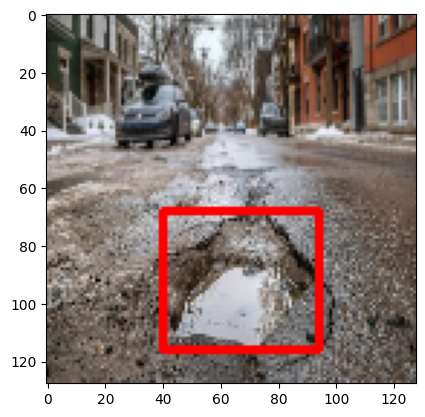

In [23]:
img, bbox = trainset[5]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

In [24]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validLoader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [25]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validLoader)))

Total no. batches in trainloader : 17
Total no. batches in validloader : 2


In [26]:
for images,bboxes in trainloader:
    break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 128, 128])
Shape of one batch bboxes : torch.Size([16, 4])


In [27]:
from torch import nn
import torchvision
import timm

In [28]:
class PotholeModel(nn.Module):
    def __init__(self) -> None:
        super(PotholeModel,self).__init__()

        self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)


    def forward(self,images,gt_bboxes=None):
        predBboxes = self.backbone(images)

        if gt_bboxes != None:
            loss1 = torchvision.ops.complete_box_iou_loss(predBboxes,gt_bboxes,reduction="sum")
            loss2 = nn.functional.smooth_l1_loss(predBboxes,gt_bboxes)
            return predBboxes,loss2 + loss1

        return predBboxes

In [29]:
model = PotholeModel()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

PotholeModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running

In [30]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

In [31]:
def train(model,dataLoader,optimizer):
    total_loss = 0
    model.train()

    for data in tqdm(dataLoader):
        images,gt_bboxes = data
        images,gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images,gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataLoader)

In [32]:
def eval(model,dataLoader):
    total_loss = 0
    model.eval()

    with torch.inference_mode():
        for data in tqdm(dataLoader):
            images,gt_bboxes = data
            images,gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images,gt_bboxes)

            total_loss += loss.item()

        return total_loss / len(dataLoader)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [34]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [35]:
best_valid_loss = np.inf
EPOCHS = 100  # Set number of epochs to 20
# model_path = "/content/drive/MyDrive/best_model.pt"
# model_path = "/content/drive/MyDrive/best_model_30.pt"
model_path = "/content/drive/MyDrive/best_model_singlepothole.pt"
# for i in range(EPOCHS):
#     train_loss = train(model, trainloader, optimizer)
#     valid_loss = eval(model, validLoader)

#     if valid_loss < best_valid_loss:
#         torch.save(model.state_dict(), model_path)
#         print("WEIGHTS SAVED!!")
#         best_valid_loss = valid_loss

#     print(f"Epoch : {i + 1}, train Loss : {train_loss:.4f}, valid loss : {valid_loss:.4f}")

In [36]:
# Save the model's state dictionary
torch.save(model.state_dict(), "pothole_model_checkpoint.pt")

# Load the saved checkpoint
#model = PotholeModel()  # Create a new instance of your model
#model.load_state_dict(torch.load("pothole_model_checkpoint.pt"))
#model.eval()  # Set the model to evaluation mode

In [37]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

PotholeModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running

In [38]:
# Function to calculate perceived focal length
def calculate_perceived_focal_length(bbox):
    length = bbox[3] - bbox[1]
    width = bbox[2] - bbox[0]
    pixel_length = length  # Assuming length represents pixel length
    camera_distance = 90  # Fixed camera distance in centimeters
    return (pixel_length * camera_distance) / width

In [39]:
# Dimension Estimation
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
# Dimension estimation
perceived_focal_lengths = []

for images, gt_bboxes in validLoader:
    images = images.to(DEVICE)
    # Perform inference
    with torch.no_grad():
        pred_bboxes = model(images)
    # Calculate perceived focal length for each detected pothole
    for pred_bbox in pred_bboxes:
        perceived_focal_length = calculate_perceived_focal_length(pred_bbox)
        perceived_focal_lengths.append(perceived_focal_length)

In [40]:
# Calculate average perceived focal length
average_perceived_focal_length = torch.mean(torch.tensor(perceived_focal_lengths).cpu()).item()
print(f"Average Perceived Focal Length: {average_perceived_focal_length} cm")

Average Perceived Focal Length: 71.5342788696289 cm


In [41]:
def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

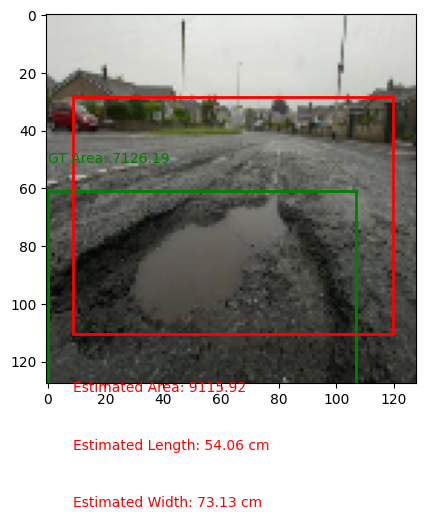

In [42]:
# Load the best model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Function to calculate dimension estimation
def calculate_dimensions(bbox):
    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.squeeze().tolist()

    # Calculate length and width of the bounding box
    length = ymax - ymin
    width = xmax - xmin

    # Calculate area of the pothole
    area = length * width

    # Estimate actual dimensions using the perceived focal length
    actual_length = (perceived_focal_length * length) / IMG_SIZE  # Assuming image size is used for scaling
    actual_width = (perceived_focal_length * width) / IMG_SIZE

    return actual_length, actual_width, area

# Function to compare plots with dimension estimation
def compare_plots_with_dimension(image, gt_bbox, out_bbox):
    # Perform dimension estimation
    actual_length, actual_width, area = calculate_dimensions(out_bbox)

    # Plot the image with bounding boxes and dimension estimation
    fig, ax = plt.subplots()
    ax.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())

    # Plot ground truth bounding box
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox
    gt_length = gt_ymax - gt_ymin
    gt_width = gt_xmax - gt_xmin
    gt_area = gt_length * gt_width
    ax.add_patch(plt.Rectangle((gt_xmin, gt_ymin), gt_width, gt_length, edgecolor='g', facecolor='none', linewidth=2))
    ax.text(gt_xmin, gt_ymin - 10, f'GT Area: {gt_area:.2f}', color='g', fontsize=10)

    # Plot detected bounding box
    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox.squeeze().tolist()
    out_length = out_ymax - out_ymin
    out_width = out_xmax - out_xmin
    ax.add_patch(plt.Rectangle((out_xmin, out_ymin), out_width, out_length, edgecolor='r', facecolor='none', linewidth=2))
    ax.text(out_xmin, out_ymax + 20, f'Estimated Area: {area:.2f}', color='r', fontsize=10)
    ax.text(out_xmin, out_ymax + 40, f'Estimated Length: {actual_length:.2f} cm', color='r', fontsize=10)
    ax.text(out_xmin, out_ymax + 60, f'Estimated Width: {actual_width:.2f} cm', color='r', fontsize=10)

    plt.show()

# Perform inference on a sample image and visualize with dimension estimation
image, gt_bbox = validset[5]
image = image.unsqueeze(0).to(DEVICE)
out_bbox = model(image)

compare_plots_with_dimension(image, gt_bbox, out_bbox)

tensor([[  8.6693,  28.2243, 119.7159, 110.3153]])
tensor([  0.2844,  61.0133, 106.6667, 128.0000])


tensor(0.4234)

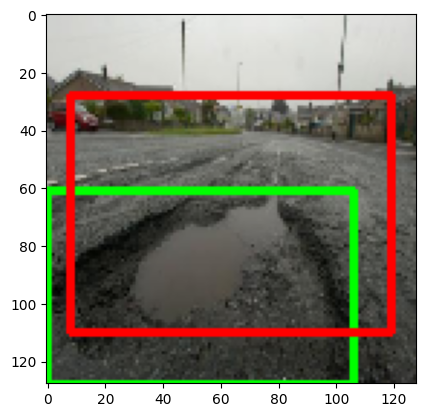

In [43]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[5]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

bb_intersection_over_union(gt_bbox, out_bbox[0])


tensor([[46.2615, 55.8605, 74.0565, 77.0145]])
tensor([45.8667, 49.6000, 80.3556, 81.7778])


tensor(0.5298)

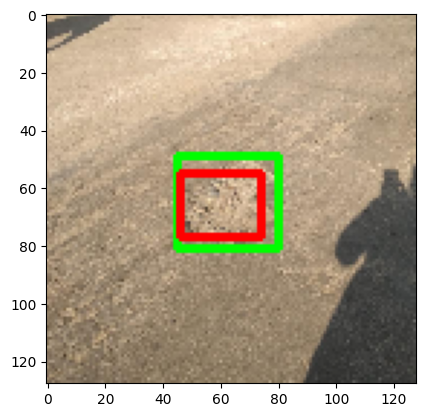

In [44]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[12]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)


bb_intersection_over_union(gt_bbox, out_bbox[0])

tensor([[47.3217, 47.8857, 81.6849, 69.9532]])
tensor([34.8444, 55.2889, 68.8000, 79.8222])


tensor(0.2468)

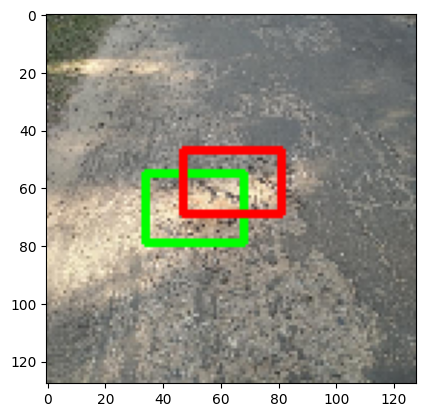

In [45]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[13]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

bb_intersection_over_union(gt_bbox, out_bbox[0])

tensor([[44.9458, 52.9161, 75.5284, 73.9786]])
tensor([ 42.8444,  53.8667, 106.6667,  70.5778])


tensor(0.4260)

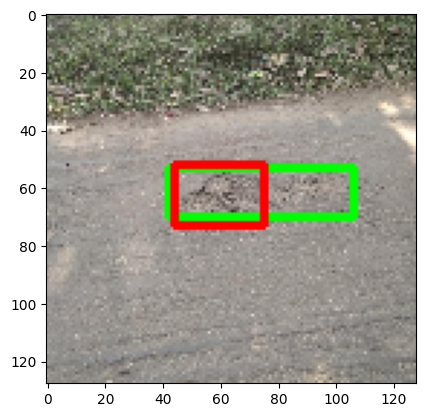

In [46]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[15]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

bb_intersection_over_union(gt_bbox, out_bbox[0])

tensor([[ 18.9459,  18.7576, 118.6537, 112.2744]])
tensor([  3.5294,   8.1067, 120.0000, 128.0000])


tensor(0.6677)

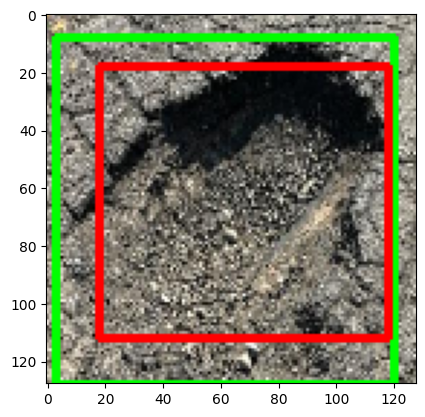

In [47]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[23]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

bb_intersection_over_union(gt_bbox, out_bbox[0])

tensor([[46.1044, 50.6901, 77.7804, 71.8679]])
tensor([45.6889, 54.4000, 67.9111, 72.7111])


tensor(0.5466)

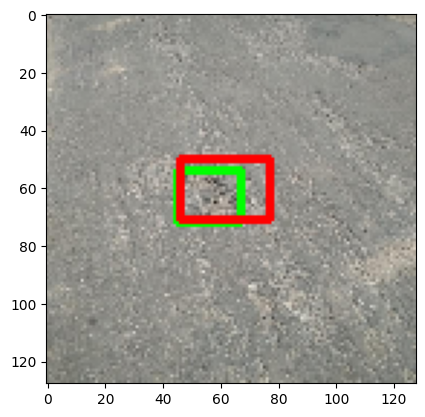

In [48]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
with torch.inference_mode():
    image, gt_bbox = validset[25]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)

bb_intersection_over_union(gt_bbox, out_bbox[0])

In [49]:
iou = []
gt_bboxes = []
out_bboxes = []
for i in range(len(validset)):
  model.eval()
  with torch.inference_mode():
    image, gt_bbox = validset[i]
    gt_bboxes.append(gt_bbox)
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)
    out_bboxes.append(out_bbox)
  bbox_iou = bb_intersection_over_union(gt_bbox, out_bbox[0])
  iou.append(bbox_iou)

In [50]:
np.mean(iou)

np.float32(0.47963965)

tensor([[47.9924, 43.7447, 76.7374, 62.8814]])
[40, 40, 78, 78]


tensor(0.3809)

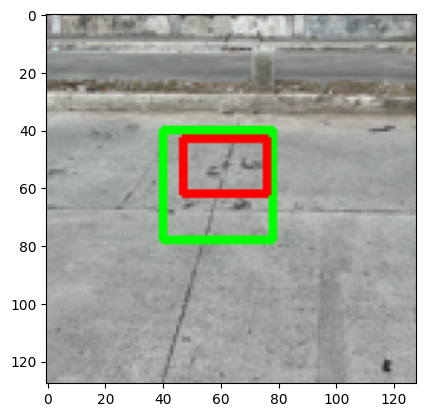

In [51]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8906.jpg"
# test_img = get_file_as_tensor("/content/drive/MyDrive/157-Potholes-Compressed/IMG_8883.jpg")
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(40, 40), (78, 78)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [40, 40, 78, 78]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)

    print(out_bbox)
    print(gt_bbox)
bb_intersection_over_union(gt_bbox, out_bbox[0])

tensor([[39.9227, 38.2906, 77.1000, 66.1019]])
[40, 40, 78, 78]
tensor(0.3831)
0


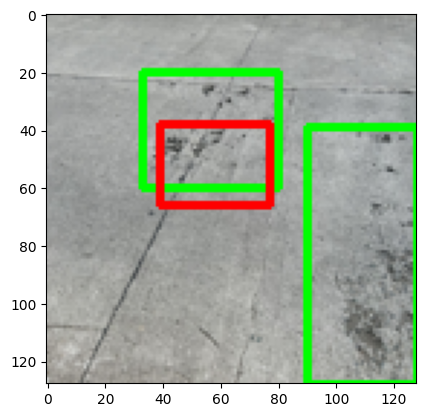

In [52]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8907.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(33, 20), (80, 60)], outline='green')
test_img_draw.rectangle([(90, 39), (128, 128)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox_1 = [33, 20, 80, 60]
    gt_bbox_2 = [90, 39, 128, 128]
    out_bbox = model(image)
    compare_plots(image,gt_bbox_1,out_bbox)
    compare_plots(image,gt_bbox_2,out_bbox)

    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox_1, out_bbox[0]))
print(bb_intersection_over_union(gt_bbox_2, out_bbox[0]))

tensor([[45.3518, 48.2164, 85.3745, 81.6627]])
[40, 40, 78, 78]
tensor(0.0137)
tensor(0.0806)


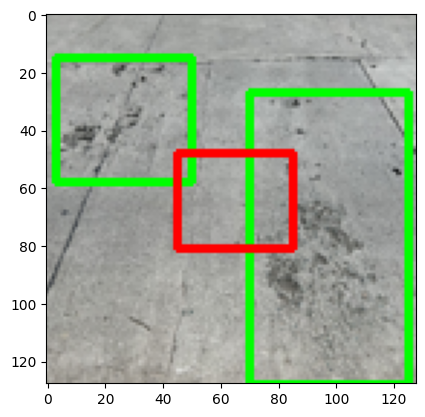

In [53]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8908.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(3, 15), (50, 58)], outline='green')
test_img_draw.rectangle([(70, 27), (125, 128)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox_1 = [3, 15, 50, 58]
    gt_bbox_2 = [70, 27, 125, 128]
    out_bbox = model(image)
    compare_plots(image,gt_bbox_1,out_bbox)
    compare_plots(image,gt_bbox_2,out_bbox)

    print(out_bbox)
    print(gt_bbox)
print(bb_intersection_over_union(gt_bbox_1, out_bbox[0]))
print(bb_intersection_over_union(gt_bbox_2, out_bbox[0]))

tensor([[46.5798, 41.4950, 94.1229, 69.1218]])
[49, 35, 87, 58]
tensor(0.4020)


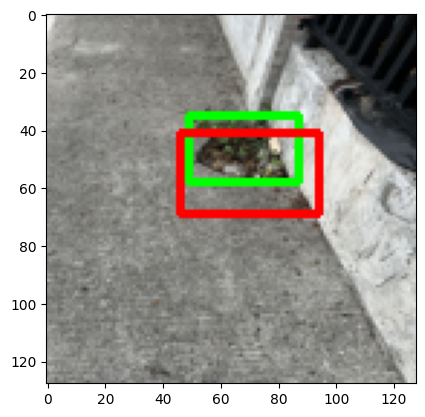

In [54]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8910.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(49, 35), (87, 58)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [49, 35, 87, 58]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))


tensor([[ 18.1367,  14.1375, 105.4870, 109.8792]])
[43, 25, 73, 78]
0.19012154088408337


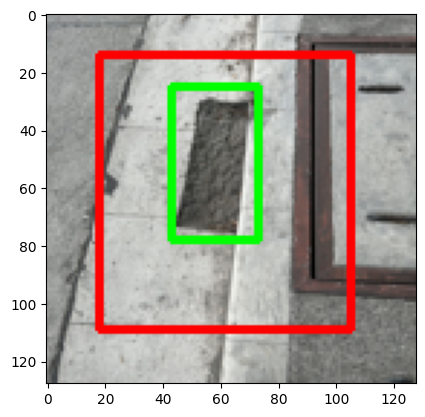

In [55]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8911.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(43, 25), (73, 78)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [43, 25, 73, 78]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[ 38.7586,  24.9314,  82.7879, 114.3614]])
[38, 43, 88, 84]
tensor(0.4316)


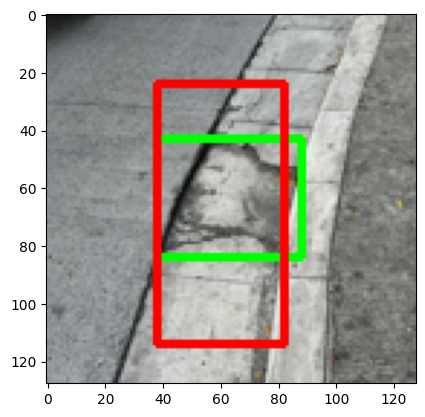

In [56]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8912.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(38, 43), (88, 84)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [38, 43, 88, 84]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[45.5126, 44.2809, 78.1831, 68.0828]])
[25, 35, 80, 74]
tensor(0.3625)


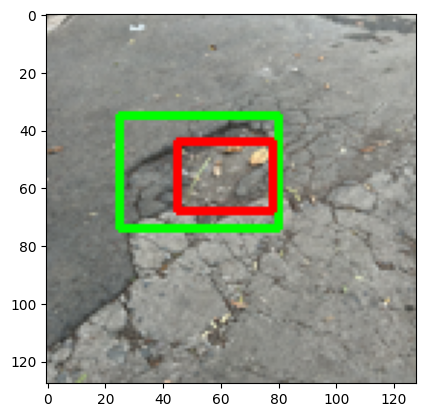

In [57]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8913.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(25, 35), (80, 74)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [25, 35, 80, 74]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[48.0616, 37.5646, 82.1412, 75.9864]])
[45, 25, 88, 102]
tensor(0.3955)


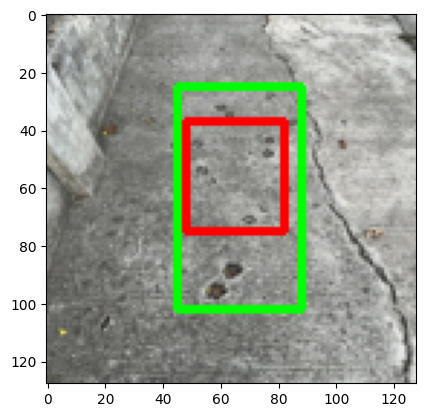

In [58]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8914.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(45, 25), (88, 102)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [45, 25, 88, 102]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[42.1385, 48.3915, 81.5145, 74.9432]])
[40, 40, 88, 88]
tensor(0.4538)


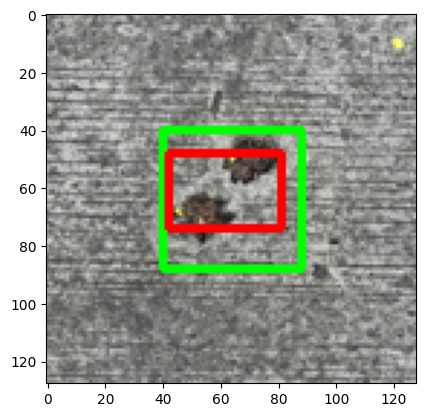

In [59]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8915.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(40, 40), (88, 88)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [40, 40, 88, 88]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)

print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[ 38.3020,  42.4625,  91.9603, 102.1440]])
[38, 35, 90, 119]
tensor(0.6879)


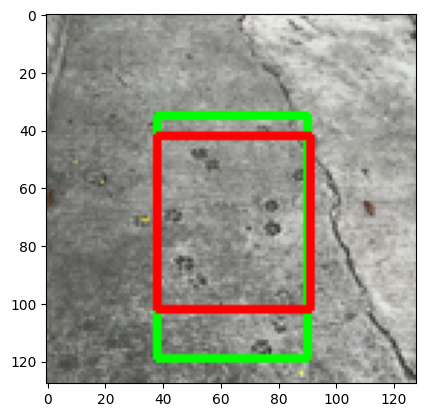

In [60]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8916.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(38, 35), (90, 119)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [38, 35, 90, 119]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[ 38.6064,  55.5533,  92.5514, 106.4215]])
[0, 50, 85, 120]
tensor(0.3726)


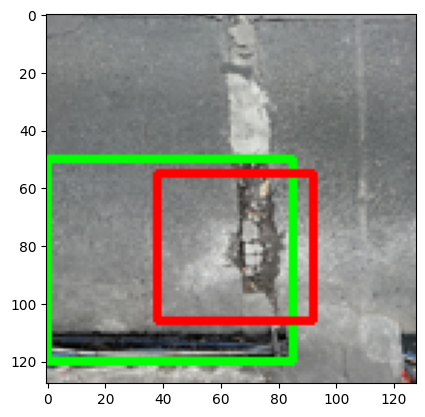

In [61]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8889.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(0, 50), (85, 120)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [0, 50, 85, 120]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[25.7858, 38.1566, 80.1558, 97.3232]])
[0, 30, 70, 110]
tensor(0.4219)


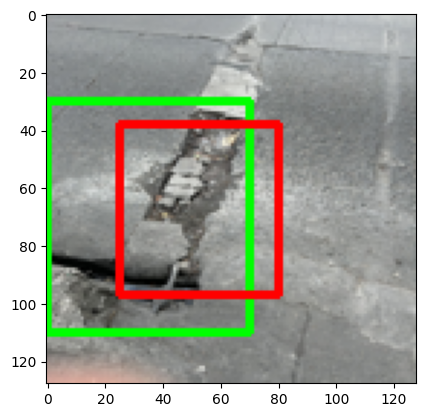

In [62]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8888.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(0, 30), (70, 110)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [0, 30, 70, 110]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[43.2983, 41.7708, 85.7988, 74.3536]])
[0, 20, 97, 85]
tensor(0.2196)


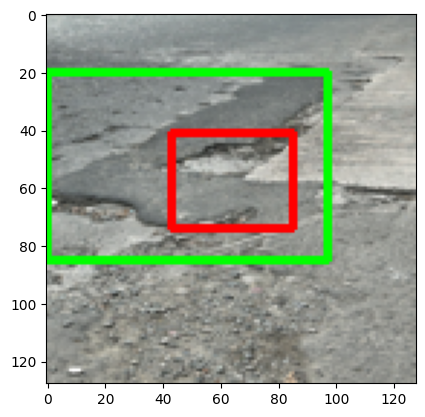

In [63]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8887.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(0, 20), (97, 85)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [0, 20, 97, 85]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[ 47.8304,  58.2036,  95.7154, 101.6989]])
[55, 85, 80, 100]
0.18004876789674204


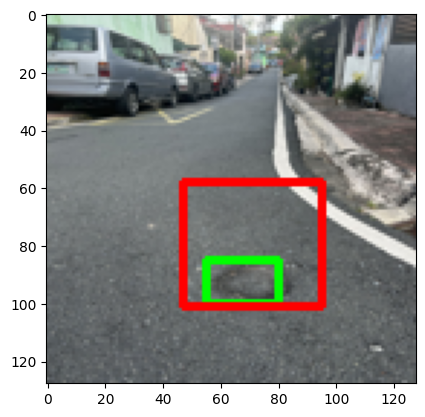

In [64]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8884.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(55, 85), (80, 100)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [55, 85, 80, 100]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[47.8030, 54.8282, 76.1746, 73.3464]])
[37, 63, 70, 87]
tensor(0.2111)


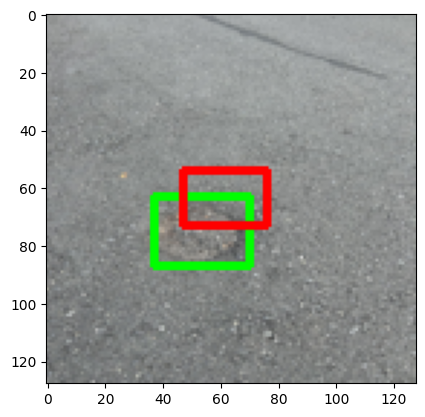

In [65]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8883.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(37, 63), (70, 87)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [37, 63, 70, 87]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[47.3894, 55.0498, 73.3987, 74.7824]])
[5, 5, 70, 40]
0


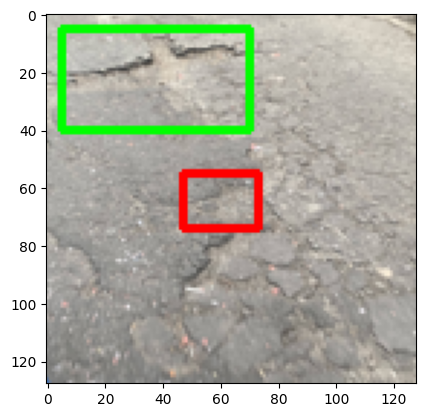

In [66]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_2373.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(5, 5), (70, 40)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [5, 5, 70, 40]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[48.3387, 51.3792, 69.8060, 65.6839]])
[40, 20, 120, 90]
tensor(0.0548)


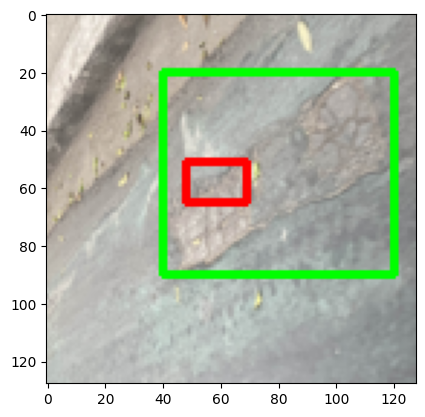

In [67]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_2372.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(40, 20), (120, 90)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [40, 20, 120, 90]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[42.1134, 41.7563, 76.6370, 72.4089]])
[45, 40, 70, 70]
tensor(0.6407)


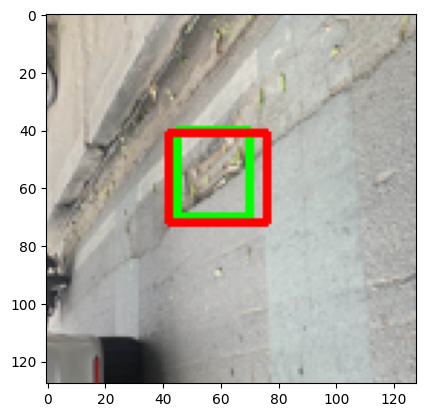

In [68]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_2371.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(45, 40), (70, 70)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [45, 40, 70, 70]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[42.2214, 41.3135, 72.4845, 69.4320]])
[18, 30, 95, 110]
tensor(0.1381)


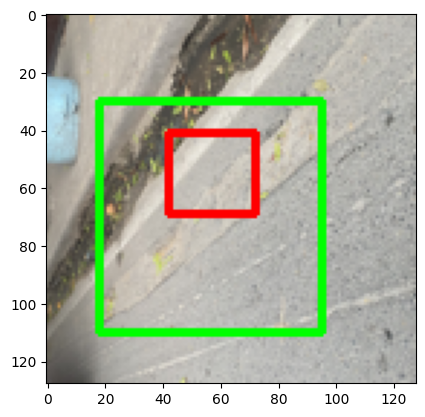

In [69]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_2370.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(18, 30), (95, 110)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [18, 30, 95, 110]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[31.1859, 42.0671, 82.9302, 84.8741]])
[7, 22, 105, 70]
tensor(0.2641)


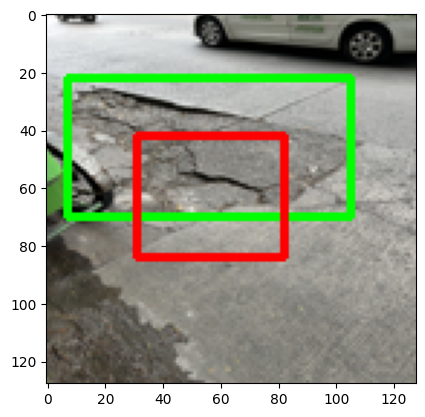

In [70]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8892.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(7, 22), (105, 70)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [7, 22, 105, 70]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[27.9432, 44.8732, 84.2634, 84.2207]])
[25, 35, 90, 87]
tensor(0.6556)


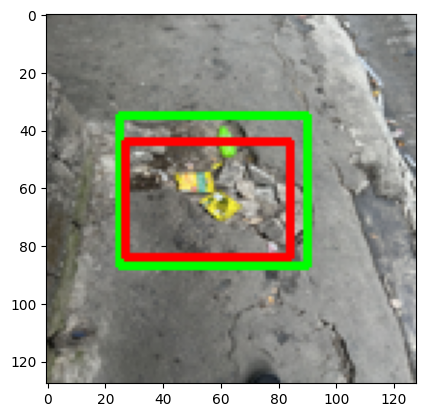

In [71]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8893.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(25, 35), (90, 87)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [25, 35, 90, 87]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

tensor([[44.8401, 33.6348, 82.6247, 69.8520]])
[40, 18, 80, 87]
tensor(0.4460)


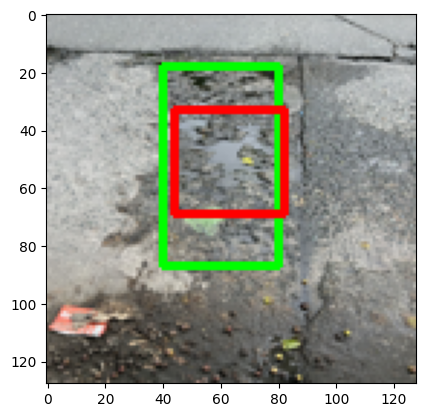

In [72]:
path = "/content/drive/MyDrive/157-Potholes-Compressed/IMG_8894.jpg"
test_img = Image.open(path)
test_img = test_img.resize((128, 128))
test_img_draw = ImageDraw.Draw(test_img)
test_img_draw.rectangle([(40, 18), (80, 87)], outline='green')
plt.imshow(test_img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
test_img_tensor = transform(test_img)/255

model.eval()
with torch.inference_mode():
    image = test_img_tensor
    image = image.unsqueeze(0).to(DEVICE)
    gt_bbox = [40, 18, 80, 87]
    out_bbox = model(image)
    compare_plots(image,gt_bbox,out_bbox)
    print(out_bbox)
    print(gt_bbox)
'[]'
print(bb_intersection_over_union(gt_bbox, out_bbox[0]))

30
30
30
Precision: 1.000
Recall:    0.900
Accuracy:  0.900


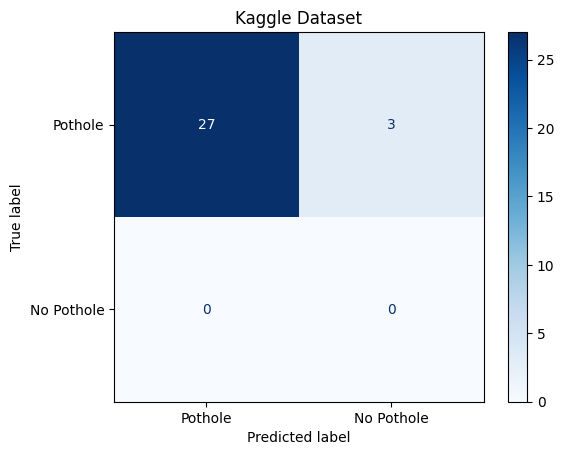

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

iou = []
gt_bboxes = []
out_bboxes = []

for i in range(len(validset)):
    model.eval()
    with torch.inference_mode():
        image, gt_bbox = validset[i]
        gt_bboxes.append(gt_bbox)
        image = image.unsqueeze(0).to(DEVICE)
        out_bbox = model(image)
        out_bboxes.append(out_bbox)
    bbox_iou = bb_intersection_over_union(gt_bbox, out_bbox[0])
    iou.append(bbox_iou)

print(len(iou))
print(len(gt_bboxes))
print(len(out_bboxes))

y_true = []
y_pred = []
iou_threshold = 0.2

for gt_bbox, pred_bbox_list in zip(gt_bboxes, out_bboxes):
    gt_present = gt_bbox is not None and isinstance(gt_bbox, (list, tuple, torch.Tensor)) and len(gt_bbox) > 0
    pred_present = pred_bbox_list is not None and len(pred_bbox_list) > 0

    if gt_present:
        y_true.append(1)
        if pred_present:
            best_iou = bb_intersection_over_union(gt_bbox, pred_bbox_list[0])
            y_pred.append(1 if best_iou >= iou_threshold else 0)
        else:
            y_pred.append(0)
    else:
        y_true.append(0)
        y_pred.append(1 if pred_present else 0)

# metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Accuracy:  {accuracy:.3f}")

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pothole", "No Pothole"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Kaggle Dataset")
plt.show()

Precision: 0.913
Recall:    0.778
Accuracy:  0.724


<function matplotlib.pyplot.show(close=None, block=None)>

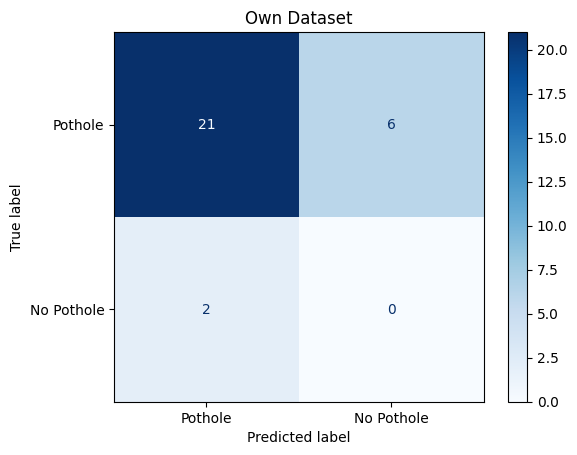

In [77]:
iou_1 = [0.3809, 0.4212, 0.0928,0.402,0.1901,0.4316,0.3625,0.3955,0.4538,0.6556,0.446,0.2694,0.4093,0,0.5819,0.641,0.1092,0.3163,0.37,0.1381,0.6407,0.0548,0,0.2111,0.18,0.2196,0.4219,0.3726,0.2641]
iou_threshold = 0.2
y_true = []
y_pred = []

# if iou is 0, it should be classified as false positive
# if iou > iou_threshold, classify it as true positive
# iou < iou_threshold, classify it as false positive

for iou in iou_1:
    if iou == 0:
        y_true.append(0)
        y_pred.append(1)

    elif iou > iou_threshold:
        y_true.append(1)
        y_pred.append(1)
    else:
        y_true.append(1)
        y_pred.append(0)


# metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Accuracy:  {accuracy:.3f}")

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pothole", "No Pothole"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Own Dataset")
plt.show